In [1]:
# 1. Import Libraries & Set Paths
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
import joblib

# --- Paths ---
RAW_PATH = "../data/raw/train.csv"
PROCESSED_PATH = "../data/processed/"
MODEL_PATH = "../models/"

os.makedirs(PROCESSED_PATH, exist_ok=True)
os.makedirs(MODEL_PATH, exist_ok=True)

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   10999 non-null  int64 
 1   Warehouse_block      10999 non-null  object
 2   Mode_of_Shipment     10999 non-null  object
 3   Customer_care_calls  10999 non-null  int64 
 4   Customer_rating      10999 non-null  int64 
 5   Cost_of_the_Product  10999 non-null  int64 
 6   Prior_purchases      10999 non-null  int64 
 7   Product_importance   10999 non-null  object
 8   Gender               10999 non-null  object
 9   Discount_offered     10999 non-null  int64 
 10  Weight_in_gms        10999 non-null  int64 
 11  Reached.on.Time_Y.N  10999 non-null  int64 
dtypes: int64(8), object(4)
memory usage: 1.0+ MB
None


,ID,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
count,10999.00000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000,10999.000000
mean,5500.00000,4.054459,2.990545,210.196836,3.567597,13.373216,3634.016729,0.596691
std,3175.28214,1.141490,1.413603,48.063272,1.522860,16.205527,1635.377251,0.490584
min,1.00000,2.000000,1.000000,96.000000,2.000000,1.000000,1001.000000,0.000000
25%,2750.50000,3.000000,2.000000,169.000000,3.000000,4.000000,1839.500000,0.000000
50%,5500.00000,4.000000,3.000000,214.000000,3.000000,7.000000,4149.000000,1.000000
75%,8249.50000,5.000000,4.000000,251.000000,4.000000,10.000000,5050.000000,1.000000
max,10999.00000,7.000000,5.000000,310.000000,10.000000,65.000000,7846.000000,1.000000


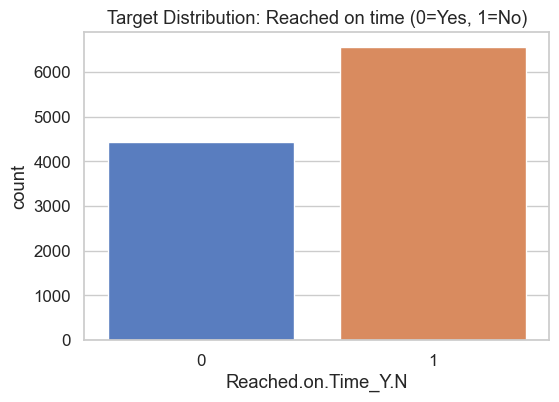

Reached.on.Time_Y.N
1    0.596691
0    0.403309
Name: proportion, dtype: float64


In [2]:
# 2. Load Data & Initial EDA
df = pd.read_csv(RAW_PATH)
display(df.head())
print(df.info())
display(df.describe())

# Target distribution
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="muted", font_scale=1.1)

plt.figure(figsize=(6,4))
sns.countplot(x="Reached.on.Time_Y.N", data=df)
plt.title("Target Distribution: Reached on time (0=Yes, 1=No)")
plt.show()

print(df["Reached.on.Time_Y.N"].value_counts(normalize=True))

In [3]:
# 3. Train/Validation/Test Split
target = "Reached.on.Time_Y.N"
X = df.drop(columns=[target, "ID"])
y = df[target]

# Split: Train (70%) / Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

# Split Temp into Validation (15%) / Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Save processed data
for name, X_, y_ in zip(["train","val","test"], [X_train,X_val,X_test],[y_train,y_val,y_test]):
    pd.concat([X_, y_], axis=1).to_csv(f"{PROCESSED_PATH}{name}.csv", index=False)

In [4]:
# 4. Feature Engineering
def feature_engineering(df):
    df = df.copy()
    # Interaction features
    df["discount_ratio"] = df["Discount_offered"] / (df["Cost_of_the_Product"] + 1e-5)
    df["weight_per_purchase"] = df["Weight_in_gms"] / (df["Prior_purchases"] + 1)
    df["rating_x_calls"] = df["Customer_rating"] * df["Customer_care_calls"]
    # Product importance numeric
    importance_map = {"low":1, "medium":2, "high":3}
    df["Product_importance_num"] = df["Product_importance"].map(importance_map)
    df["important_discount"] = df["Product_importance_num"] * df["Discount_offered"]
    # Log transform
    df["log_cost"] = np.log1p(df["Cost_of_the_Product"])
    df["log_weight"] = np.log1p(df["Weight_in_gms"])
    # Optional binning
    df["calls_bin"] = pd.cut(df["Customer_care_calls"], bins=[-1,2,4,10], labels=["Low","Medium","High"])
    df["rating_bin"] = pd.cut(df["Customer_rating"], bins=[0,2,4,5], labels=["Bad","Neutral","Good"])
    return df

# Apply feature engineering
train_df = feature_engineering(pd.read_csv(f"{PROCESSED_PATH}train.csv"))
val_df = feature_engineering(pd.read_csv(f"{PROCESSED_PATH}val.csv"))
test_df = feature_engineering(pd.read_csv(f"{PROCESSED_PATH}test.csv"))

# Save FE files
for df_, name in zip([train_df,val_df,test_df], ["train_fe","val_fe","test_fe"]):
    df_.to_csv(f"{PROCESSED_PATH}{name}.csv", index=False)

In [5]:
# 5. Define Features & Target
categorical_features = ["Warehouse_block","Mode_of_Shipment","Product_importance","Gender","calls_bin","rating_bin"]
numerical_features = [
    "Customer_care_calls","Customer_rating","Cost_of_the_Product","Prior_purchases",
    "Discount_offered","Weight_in_gms","discount_ratio","weight_per_purchase",
    "rating_x_calls","Product_importance_num","important_discount","log_cost","log_weight"
]

train_df = pd.read_csv(f"{PROCESSED_PATH}train_fe.csv")
val_df   = pd.read_csv(f"{PROCESSED_PATH}val_fe.csv")
test_df  = pd.read_csv(f"{PROCESSED_PATH}test_fe.csv")

X_train = train_df[categorical_features + numerical_features]
y_train = train_df[target]
X_val = val_df[categorical_features + numerical_features]
y_val = val_df[target]
X_test = test_df[categorical_features + numerical_features]
y_test = test_df[target]

In [6]:
# 6. Preprocessing & Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", StandardScaler(), numerical_features)
    ]
)

# Class balancing
pos_ratio = y_train.value_counts()[0] / y_train.value_counts()[1]

xgb_params = {
    'subsample': 0.8,
    'n_estimators': 500,
    'min_child_weight': 1,
    'max_depth': 9,
    'learning_rate': 0.2,
    'gamma': 0.1,
    'colsample_bytree': 1.0,
    'scale_pos_weight': pos_ratio,
    'random_state': 42,
    'use_label_encoder': False,
    'eval_metric': 'logloss'
}

pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("xgb", XGBClassifier(**xgb_params))
])

In [7]:
# 7. Train Model
pipeline.fit(X_train, y_train)

c:\Users\nghoo\AppData\Local\anaconda3\envs\e-commerce_env\lib\site-packages\xgboost\training.py:183: UserWarning: [20:59:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Warehouse_block',
                                                   'Mode_of_Shipment',
                                                   'Product_importance',
                                                   'Gender', 'calls_bin',
                                                   'rating_bin']),
                                                 ('num', StandardScaler(),
                                                  ['Customer_care_calls',
                                                   'Customer_rating',
                                                   'Cost_of_the_Product',
                                                   'Prior_purchases',
                                                   'Discount_offered',
                                                   'Weight_in_gms',
                                                   'disc...
                               feature_types=None, feature_weights=None,
                               gamma=0.1, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=9, max_leaves=None, min_child_weight=1,
                               missing=nan, monotone_constraints=None,
                               multi_strategy=None, n_estimators=500,
                               n_jobs=None, num_parallel_tree=None, ...))])

In [ ]:
# 8. Evaluate Model
y_val_pred = pipeline.predict(X_val)
y_val_prob = pipeline.predict_proba(X_val)[:,1]

print(f"Validation F1-score: {f1_score(y_val, y_val_pred):.4f}")
print(f"Validation ROC-AUC : {roc_auc_score(y_val, y_val_prob):.4f}")
print("\nClassification Report:\n", classification_report(y_val, y_val_pred))

Validation F1-score: 0.6827
Validation ROC-AUC : 0.7140

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.63      0.59       665
           1       0.72      0.65      0.68       985

    accuracy                           0.64      1650
   macro avg       0.63      0.64      0.63      1650
weighted avg       0.65      0.64      0.64      1650



In [9]:
# 9. Feature Importance
xgb_model = pipeline.named_steps["xgb"]

try:
    feature_names = pipeline.named_steps["preprocessor"].get_feature_names_out()
except:
    feature_names = categorical_features + numerical_features

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({"feature": feature_names, "importance": importances}).sort_values(by="importance", ascending=False)
print("\nTop 15 important features:")
print(feat_imp_df.head(15))


Top 15 important features:
                         feature  importance
23         num__Discount_offered    0.301457
22          num__Prior_purchases    0.047056
14            cat__calls_bin_Low    0.035025
17          cat__rating_bin_Good    0.028563
24            num__Weight_in_gms    0.027348
15         cat__calls_bin_Medium    0.027277
2         cat__Warehouse_block_C    0.027008
0         cat__Warehouse_block_A    0.026582
16           cat__rating_bin_Bad    0.026563
8   cat__Product_importance_high    0.025950
6     cat__Mode_of_Shipment_Road    0.025263
1         cat__Warehouse_block_B    0.025218
21      num__Cost_of_the_Product    0.024864
13           cat__calls_bin_High    0.024765
3         cat__Warehouse_block_D    0.024742


In [10]:
# 10. Save Model & Preprocessor
joblib.dump(pipeline, f"{MODEL_PATH}xgb_pipeline.pkl")
print("\nSaved XGBoost pipeline with preprocessor.")


Saved XGBoost pipeline with preprocessor.
